# FRiP

Plots for single-cell fraction of reads in peak sets (FRiP). 

For Fig1 subfigure, would plot the FRiP in iPSC peaks and Fibroblast peaks.
For Fig2 subfigure, plot FRiP in peaks with O,S,K motifs.

Inputs:

1. `metadata.tsv` with UMAP/densMAP coordinates and total fragments/insertions.
2. Single-cell counts matrix derived from snapATAC with corresponding peaks.
3. Peak sets:
      - Fig 1: with Fibroblast and iPSC peaks.
      - Fig 2: with O,S,K motifs

In [1]:
library(Matrix)
library(ggplot2)
library(patchwork)
library(GenomicRanges)
library(scales)
library(rtracklayer)

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:Matrix’:

    which


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loading

In [2]:
DAYS = c("D0", "D2", "D4", "D6", "D8", "D10", "D12", "D14")

## Loading Inputs

### MetaData

In [3]:
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../analysis/20200206_pmat_snapATAC/sessions/20200520_n68916/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$cells = rownames(metaData) # for cicero
metaData$sample = factor(metaData$sample, levels=DAYS)
dim(metaData)
head(metaData, 5)

[1] 68916     5

barcode          sample umap1    umap2    
D0_AAACAACGACGATTAC AAACAACGACGATTAC D0     6.565758 -8.649868
D0_AAACAACGAGCGCACT AAACAACGAGCGCACT D0     5.604522 -7.835411
D0_AAACACGCTACGCCAC AAACACGCTACGCCAC D0     5.130516 -7.593246
D0_AAACACGCTAGTACGG AAACACGCTAGTACGG D0     4.926843 -8.365463
D0_AAACACGCTCCTCAAA AAACACGCTCCTCAAA D0     6.056337 -5.647577
                    cells              
D0_AAACAACGACGATTAC D0_AAACAACGACGATTAC
D0_AAACAACGAGCGCACT D0_AAACAACGAGCGCACT
D0_AAACACGCTACGCCAC D0_AAACACGCTACGCCAC
D0_AAACACGCTAGTACGG D0_AAACACGCTAGTACGG
D0_AAACACGCTCCTCAAA D0_AAACACGCTCCTCAAA

In [4]:
# this is a kludge for now, clusters AND total insertions should also be present in same metaData as above
snapATAC_metaData = read.table("../analysis/20200122_snapATAC/snapATAC_sessions/20200518_n76052/metadata.tsv", header = T)
rownames(snapATAC_metaData) = paste(snapATAC_metaData$sample, snapATAC_metaData$barcode, sep='_')

metaData$cluster = snapATAC_metaData[rownames(metaData), "cluster"] 
metaData$total_insertions = snapATAC_metaData[rownames(metaData), "TN"] 
head(metaData)

barcode          sample umap1    umap2    
D0_AAACAACGACGATTAC AAACAACGACGATTAC D0     6.565758 -8.649868
D0_AAACAACGAGCGCACT AAACAACGAGCGCACT D0     5.604522 -7.835411
D0_AAACACGCTACGCCAC AAACACGCTACGCCAC D0     5.130516 -7.593246
D0_AAACACGCTAGTACGG AAACACGCTAGTACGG D0     4.926843 -8.365463
D0_AAACACGCTCCTCAAA AAACACGCTCCTCAAA D0     6.056337 -5.647577
D0_AAACACGCTCGAGTGA AAACACGCTCGAGTGA D0     3.408866 -9.058377
                    cells               cluster total_insertions
D0_AAACAACGACGATTAC D0_AAACAACGACGATTAC 5       53446           
D0_AAACAACGAGCGCACT D0_AAACAACGAGCGCACT 5       27136           
D0_AAACACGCTACGCCAC D0_AAACACGCTACGCCAC 5       23308           
D0_AAACACGCTAGTACGG D0_AAACACGCTAGTACGG 6       18466           
D0_AAACACGCTCCTCAAA D0_AAACACGCTCCTCAAA 5        3238           
D0_AAACACGCTCGAGTGA D0_AAACACGCTCGAGTGA 6       50468

### Insertions Count Matrix + Regions

In [5]:
pmat = readMM("../analysis/20200206_pmat_snapATAC/sessions/20200520_n68916/pmat.sparse.mm")
pmat = as(pmat, "dgCMatrix")
dim(pmat)

[1]  68916 409052

In [6]:
peak_regions = read.table("../analysis/20200206_pmat_snapATAC/sessions/20200520_n68916/peaks.bed")
names(peak_regions) = c("chr", "bp1", "bp2")
peak_regions$site_name <- paste(peak_regions$chr, peak_regions$bp1, peak_regions$bp2, sep="_")
row.names(peak_regions) <- peak_regions$site_name
dim(peak_regions)
head(peak_regions)

[1] 409052      4

chr  bp1   bp2   site_name       
chr1_10355_10867 chr1 10355 10867 chr1_10355_10867
chr1_41995_42521 chr1 41995 42521 chr1_41995_42521
chr1_46067_46593 chr1 46067 46593 chr1_46067_46593
chr1_48475_48975 chr1 48475 48975 chr1_48475_48975
chr1_51286_52235 chr1 51286 52235 chr1_51286_52235
chr1_58648_59148 chr1 58648 59148 chr1_58648_59148

In [7]:
peak_regions_gr =  GRanges(sub("_", "-", sub("_", ":", rownames(peak_regions))))

In [8]:
# check if reads at OCT promoter (none in initial version)
sum(pmat[,subjectHits(findOverlaps(GRanges(c("chr6:31170549-31170836")), peak_regions_gr))])

[1] 12150

In [9]:
pmatRowSums = Matrix::rowSums(pmat)

In [10]:
# these values should correlate well (reads in peaks vs total reads)
cor(pmatRowSums, metaData$total_insertions, method='spearman')

[1] 0.9899533

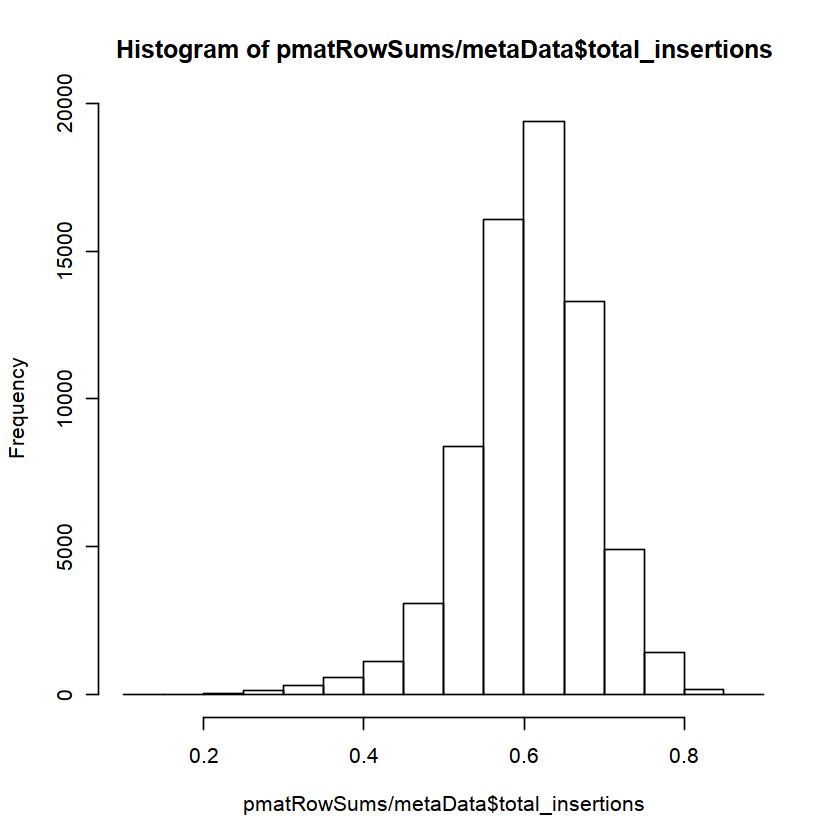

In [11]:
hist(pmatRowSums/metaData$total_insertions)

## Plotting Function

In [22]:
get_frip_plot <- function(reads_in_peaks, title, peak_subset, upper_perc=0.99) {
    plot_df = data.frame(umap1=metaData$umap1, 
                    umap2=metaData$umap2,
                    percent_reads=reads_in_peaks)
    # shuffle so days don't overlap
    plot_df = plot_df[sample(dim(plot_df)[1]), ]


    frip_plot <- ggplot(plot_df) +
        geom_point(size=0.5, stroke=0, alpha=1, aes(x=umap1 , y=umap2, col=percent_reads)) +
        scale_color_viridis_c(limits=c(quantile(reads_in_peaks, 0.1), 
                                   quantile(reads_in_peaks, upper_perc)), 
                          oob=squish,
                              name="Normalized\nInsertions", 
                              option = "B") +
        ggtitle(sprintf("%s (%d Mbp)",  
                        title,
                        as.integer(sum(width(peak_subset))/1e6))) + 
        theme_classic() +
        xlab("UMAP 1") + ylab("UMAP 2") +
        theme(plot.title = element_text(hjust = 0.5),
              text = element_text(size=12),
              axis.line=element_blank(),
              axis.text.x=element_blank(),
              axis.text.y=element_blank(),
              axis.ticks=element_blank(),
              panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
        coord_fixed()
    
    frip_plot
}

In [27]:
get_frip_plot_small <- function(reads_in_peaks, title, peak_subset, upper_perc=0.99) {
    plot_df = data.frame(umap1=metaData$umap1, 
                    umap2=metaData$umap2,
                    percent_reads=reads_in_peaks)
    # shuffle so days don't overlap
    plot_df = plot_df[sample(dim(plot_df)[1], 20000), ]


    frip_plot <- ggplot(plot_df) +
        geom_point(size=0.5, stroke=0, alpha=1, aes(x=umap1 , y=umap2, col=percent_reads)) +
        scale_color_viridis_c(limits=c(quantile(reads_in_peaks, 0.1), 
                                   quantile(reads_in_peaks, upper_perc)), 
                          oob=squish,
                              name="Normalized\nInsertions", 
                              option = "B") +
        ggtitle(title) + 
        theme_classic() +
        xlab("UMAP 1") + ylab("UMAP 2") +
        theme(plot.title = element_text(hjust = 0.5),
              text = element_text(size=12),
              axis.line=element_blank(),
              axis.text.x=element_blank(),
              axis.text.y=element_blank(),
              axis.ticks=element_blank(),
              legend.title = element_blank(),
              legend.text = element_blank(), # no numbers
              legend.background = element_blank(), # strip whitespace around colorbar
              legend.key.size = unit(0.15, "inches"),
              legend.position = c(0.08, 0.16), 
              panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
        coord_fixed()
    
    frip_plot
}

## Fig 1

### Peak Sets

In [13]:
fibroblast_peaks = import("/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bulk/croo/D0/peak/idr_reproducibility/idr.optimal_peak.narrowPeak.gz")
fibroblast_peaks

GRanges object with 234319 ranges and 6 metadata columns:
           seqnames              ranges strand |        name     score
              <Rle>           <IRanges>  <Rle> | <character> <numeric>
       [1]     chr1   16612605-16614026      * |        <NA>      1000
       [2]     chr9   62801936-62802834      * |        <NA>      1000
       [3]     chr1   16643949-16645198      * |        <NA>      1000
       [4]     chr7   75156324-75157647      * |        <NA>      1000
       [5]     chr7   44606346-44607283      * |        <NA>      1000
       ...      ...                 ...    ... .         ...       ...
  [234315]    chr19   18044858-18045395      * |        <NA>      1000
  [234316]     chr7 100478379-100479635      * |        <NA>      1000
  [234317]     chr3 119293672-119295459      * |        <NA>      1000
  [234318]     chr9 121246837-121247679      * |        <NA>      1000
  [234319]     chr5   96388059-96388641      * |        <NA>      1000
           signalVa

In [14]:
iPSC_peaks = import("/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bulk/croo/iPSC/peak/idr_reproducibility/idr.optimal_peak.narrowPeak.gz")
iPSC_peaks

GRanges object with 212222 ranges and 6 metadata columns:
           seqnames              ranges strand |        name     score
              <Rle>           <IRanges>  <Rle> | <character> <numeric>
       [1]     chr1   16613199-16614044      * |        <NA>      1000
       [2]     chr1   16921297-16922343      * |        <NA>      1000
       [3]     chr5 146202983-146204059      * |        <NA>      1000
       [4]    chr17   46578960-46580344      * |        <NA>      1000
       [5]     chr5   43312857-43313973      * |        <NA>      1000
       ...      ...                 ...    ... .         ...       ...
  [212218]     chr1 171898877-171899563      * |        <NA>      1000
  [212219]     chr1 171245316-171245948      * |        <NA>      1000
  [212220]     chr1 150221351-150222043      * |        <NA>       927
  [212221]     chr1   13929938-13930647      * |        <NA>      1000
  [212222]     chr1 115564039-115564865      * |        <NA>      1000
           signalVa

## Plotting

### Fibroblast Peak Set

In [15]:
peak_intersect_fibr = peak_regions_gr[unique(queryHits(findOverlaps(peak_regions_gr, fibroblast_peaks)))]
peak_intersect_fibr

GRanges object with 87585 ranges and 0 metadata columns:
          seqnames            ranges strand
             <Rle>         <IRanges>  <Rle>
      [1]     chr1     196313-196826      *
      [2]     chr1     778151-779381      *
      [3]     chr1     817132-819324      *
      [4]     chr1     826576-828254      *
      [5]     chr1     850263-850797      *
      ...      ...               ...    ...
  [87581]     chrY 19076751-19078278      *
  [87582]     chrY 19559113-19559854      *
  [87583]     chrY 19566561-19568390      *
  [87584]     chrY 19744052-19745462      *
  [87585]     chrY 20574883-20576318      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [16]:
# dividing by total insertions doesn't give a clean signal for iPSC peaks, D12/14 have overall low fraction of reads in peaks

# reads_in_fibr_peaks = Matrix::rowSums(pmat[, unique(queryHits(findOverlaps(peak_regions_gr, fibroblast_peaks)))])/metaData$total_insertions
reads_in_fibr_peaks = Matrix::rowSums(pmat[, unique(queryHits(findOverlaps(peak_regions_gr, fibroblast_peaks)))])/pmatRowSums

In [17]:
min(reads_in_fibr_peaks)
median(reads_in_fibr_peaks)
max(reads_in_fibr_peaks)

[1] 0.3180259

[1] 0.6782487

[1] 0.9335586

In [18]:
cor(reads_in_fibr_peaks, metaData$total_insertions, method='spearman')

[1] -0.02497146

In [28]:
fibr_frip = get_frip_plot_small(reads_in_fibr_peaks, "Insertions in Fibroblast Peaks", peak_intersect_fibr)

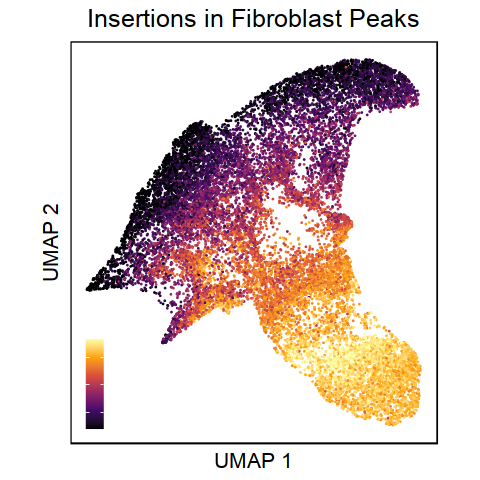

In [29]:
options(repr.plot.width = 4, repr.plot.height = 4)
fibr_frip

In [30]:
saveRDS(fibr_frip, file=sprintf("./Fig1/subfigs/%s_fibroblast_frip.rds",
                                   format(Sys.Date(), "%Y%m%d")))

In [21]:
ggsave("tmp.png", fibr_frip, height=10, width=10)

### iPSC Peak Set

In [31]:
peak_intersect_ipsc = peak_regions_gr[unique(queryHits(findOverlaps(peak_regions_gr, iPSC_peaks)))]
peak_intersect_ipsc

GRanges object with 90926 ranges and 0 metadata columns:
          seqnames            ranges strand
             <Rle>         <IRanges>  <Rle>
      [1]     chr1     778151-779381      *
      [2]     chr1     826576-828254      *
      [3]     chr1     857838-859141      *
      [4]     chr1     869645-870446      *
      [5]     chr1     904198-905035      *
      ...      ...               ...    ...
  [90922]     chrY   5002705-5003225      *
  [90923]     chrY   5215065-5215995      *
  [90924]     chrY   5708657-5710502      *
  [90925]     chrY   6130651-6131328      *
  [90926]     chrY 12438681-12439412      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [32]:
# dividing by total insertions doesn't give a clean signal for iPSC peaks, D12/14 have overall low fraction of reads in peaks

# reads_in_ipsc_peaks = Matrix::rowSums(pmat[, unique(queryHits(findOverlaps(peak_regions_gr, iPSC_peaks)))])/metaData$total_insertions
reads_in_ipsc_peaks = Matrix::rowSums(pmat[, unique(queryHits(findOverlaps(peak_regions_gr, iPSC_peaks)))])/pmatRowSums

In [33]:
min(reads_in_ipsc_peaks)
median(reads_in_ipsc_peaks)
max(reads_in_ipsc_peaks)

[1] 0.2858163

[1] 0.6011215

[1] 0.8788793

In [34]:
ipsc_frip = get_frip_plot_small(reads_in_ipsc_peaks, "Insertions in iPSC Peaks", peak_intersect_ipsc)

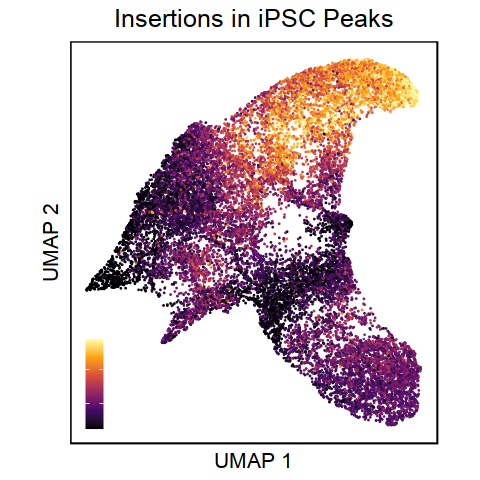

In [37]:
options(repr.plot.width = 4, repr.plot.height = 4)
ipsc_frip

In [36]:
saveRDS(ipsc_frip, file=sprintf("./Fig1/subfigs/%s_ipsc_frip.rds",
                                   format(Sys.Date(), "%Y%m%d")))

In [220]:
ggsave("tmp.png", ipsc_frip, height=10, width=10)

## Fig 2

### Peak Sets

In [30]:
OCT4_motif_gr = import("../analysis/20200522_OSK_frip/data/20200307_fine_clustering_20200520_gridmap_peakwidthnorm_n40/OCT4.bed")
OCT4_motif_gr

GRanges object with 97338 ranges and 2 metadata columns:
          seqnames            ranges strand |        name     score
             <Rle>         <IRanges>  <Rle> | <character> <numeric>
      [1]     chr1       48652-48667      + |      POU5F1      1000
      [2]     chr1       58918-58933      - |      POU5F1      1000
      [3]     chr1       58970-58985      - |      POU5F1      1000
      [4]     chr1   1013572-1013587      - |      POU5F1      1000
      [5]     chr1   1093092-1093107      - |      POU5F1      1000
      ...      ...               ...    ... .         ...       ...
  [97334]     chrY 19428201-19428216      - |      POU5F1      1000
  [97335]     chrY 19428406-19428421      - |      POU5F1      1000
  [97336]     chrY 19433464-19433479      + |      POU5F1      1000
  [97337]     chrY 19578794-19578804      - |      POU5F1      1000
  [97338]     chrY 19738958-19738973      + |      POU5F1      1000
  -------
  seqinfo: 24 sequences from an unspecified genom

In [31]:
SOX2_motif_gr = import("../analysis/20200522_OSK_frip/data/20200307_fine_clustering_20200520_gridmap_peakwidthnorm_n40/SOX2.bed")
SOX2_motif_gr

GRanges object with 89093 ranges and 2 metadata columns:
          seqnames            ranges strand |        name     score
             <Rle>         <IRanges>  <Rle> | <character> <numeric>
      [1]     chr1       48652-48666      + |        SOX2      1000
      [2]     chr1       58873-58887      + |        SOX2      1000
      [3]     chr1       58919-58933      - |        SOX2      1000
      [4]     chr1     840152-840166      + |        SOX2      1000
      [5]     chr1     844328-844333      - |        SOX2      1000
      ...      ...               ...    ... .         ...       ...
  [89089]     chrY 19146490-19146504      - |        SOX2      1000
  [89090]     chrY 19428202-19428216      - |        SOX2      1000
  [89091]     chrY 19428407-19428421      - |        SOX2      1000
  [89092]     chrY 19433265-19433279      + |        SOX2      1000
  [89093]     chrY 22744374-22744388      + |        SOX2      1000
  -------
  seqinfo: 24 sequences from an unspecified genom

In [32]:
KLF4_motif_gr = import("../analysis/20200522_OSK_frip/data/20200307_fine_clustering_20200520_gridmap_peakwidthnorm_n40/KLF4.bed")
KLF4_motif_gr

GRanges object with 270797 ranges and 2 metadata columns:
           seqnames            ranges strand |        name     score
              <Rle>         <IRanges>  <Rle> | <character> <numeric>
       [1]     chr1     818784-818792      - |        KLF4      1000
       [2]     chr1     827163-827171      + |        KLF4      1000
       [3]     chr1     827543-827551      + |        KLF4      1000
       [4]     chr1     827583-827591      + |        KLF4      1000
       [5]     chr1     827604-827612      + |        KLF4      1000
       ...      ...               ...    ... .         ...       ...
  [270793]     chrY 20576048-20576056      + |        KLF4      1000
  [270794]     chrY 20649238-20649246      - |        KLF4      1000
  [270795]     chrY 20925451-20925452      - |        KLF4      1000
  [270796]     chrY 20925502-20925510      - |        KLF4      1000
  [270797]     chrY 20925566-20925574      - |        KLF4      1000
  -------
  seqinfo: 24 sequences from an uns

### Plotting

### OCT4

In [33]:
peak_intersect_OCT4 = peak_regions_gr[unique(queryHits(findOverlaps(peak_regions_gr, OCT4_motif_gr)))]
peak_intersect_OCT4

GRanges object with 79966 ranges and 0 metadata columns:
          seqnames            ranges strand
             <Rle>         <IRanges>  <Rle>
      [1]     chr1       48475-48975      *
      [2]     chr1       58648-59148      *
      [3]     chr1   1012730-1014759      *
      [4]     chr1   1092842-1093354      *
      [5]     chr1   1422632-1423198      *
      ...      ...               ...    ...
  [79962]     chrY 19146202-19147039      *
  [79963]     chrY 19427730-19428650      *
  [79964]     chrY 19432984-19433743      *
  [79965]     chrY 19578220-19578954      *
  [79966]     chrY 19738671-19739171      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [34]:
# reads_in_ipsc_peaks = Matrix::rowSums(pmat[, unique(queryHits(findOverlaps(peak_regions_gr, iPSC_peaks)))])/metaData$total_insertions
reads_in_OCT4_peaks = Matrix::rowSums(pmat[, unique(queryHits(findOverlaps(peak_regions_gr, OCT4_motif_gr)))])/pmatRowSums

In [35]:
min(reads_in_OCT4_peaks)
median(reads_in_OCT4_peaks)
max(reads_in_OCT4_peaks)

[1] 0.1013116

[1] 0.1934241

[1] 0.3561043

In [36]:
OCT4_frip = get_frip_plot(reads_in_OCT4_peaks, "Insertions in OCT4 Peaks", peak_intersect_OCT4)

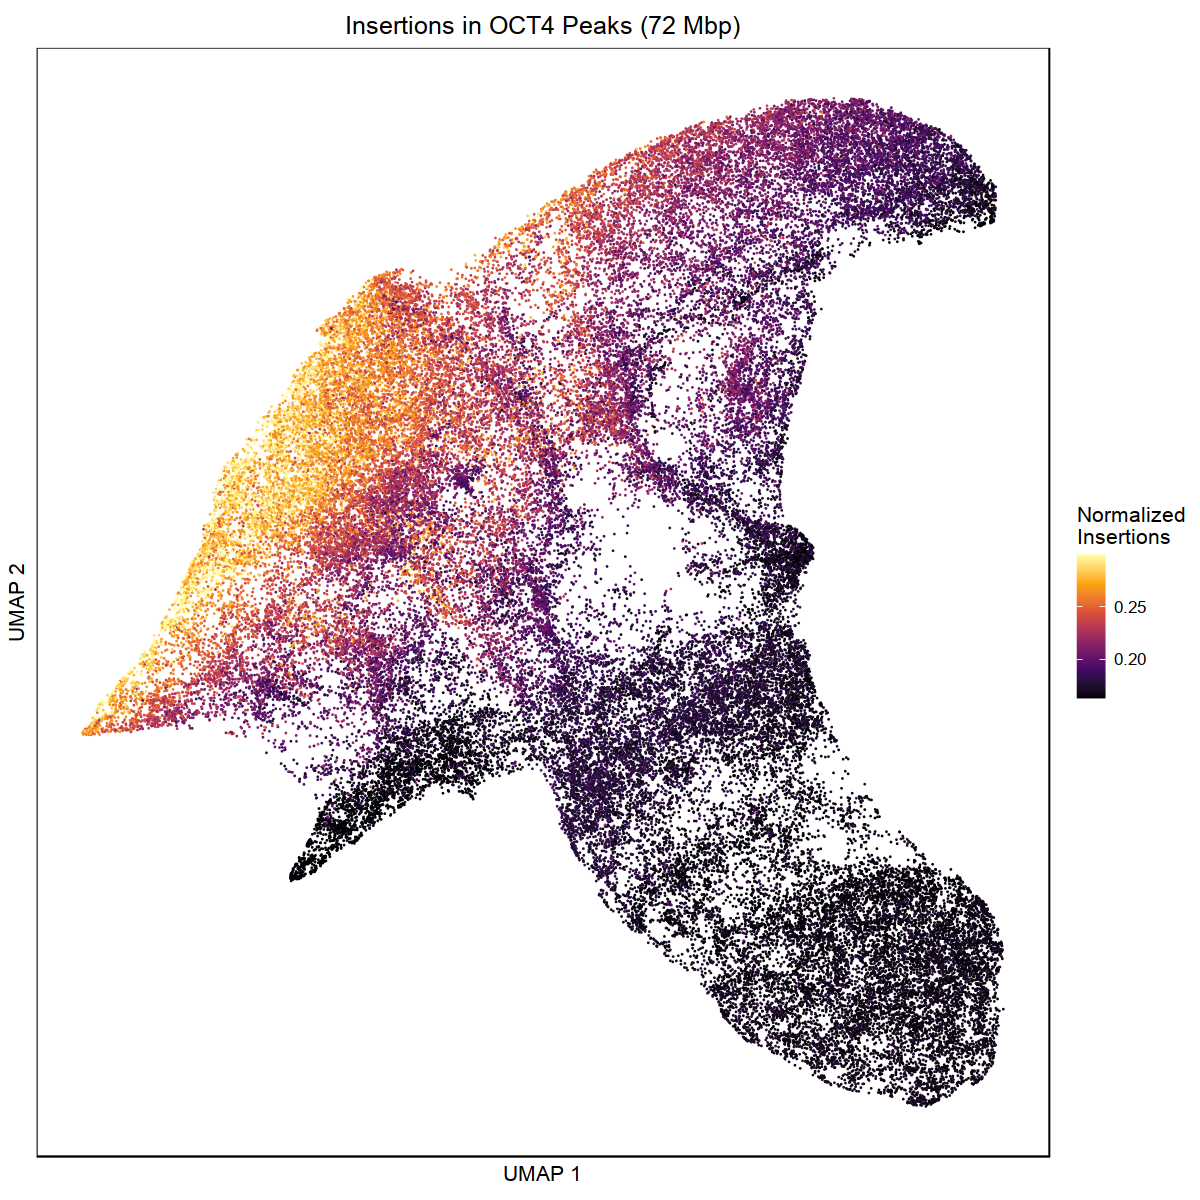

In [37]:
options(repr.plot.width = 10, repr.plot.height = 10)
OCT4_frip

In [38]:
saveRDS(OCT4_frip, file=sprintf("./Fig2/subfigs/%s_OCT4_frip.rds",
                                   format(Sys.Date(), "%Y%m%d")))

### SOX2

In [39]:
peak_intersect_SOX2 = peak_regions_gr[unique(queryHits(findOverlaps(peak_regions_gr, SOX2_motif_gr)))]
peak_intersect_SOX2

GRanges object with 74825 ranges and 0 metadata columns:
          seqnames            ranges strand
             <Rle>         <IRanges>  <Rle>
      [1]     chr1       48475-48975      *
      [2]     chr1       58648-59148      *
      [3]     chr1     839909-840409      *
      [4]     chr1     844177-844677      *
      [5]     chr1     998719-999538      *
      ...      ...               ...    ...
  [74821]     chrY 19059675-19060175      *
  [74822]     chrY 19146202-19147039      *
  [74823]     chrY 19427730-19428650      *
  [74824]     chrY 19432984-19433743      *
  [74825]     chrY 22744096-22744637      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [40]:
# reads_in_ipsc_peaks = Matrix::rowSums(pmat[, unique(queryHits(findOverlaps(peak_regions_gr, iPSC_peaks)))])/metaData$total_insertions
reads_in_SOX2_peaks = Matrix::rowSums(pmat[, unique(queryHits(findOverlaps(peak_regions_gr, SOX2_motif_gr)))])/pmatRowSums

In [41]:
min(reads_in_SOX2_peaks)
median(reads_in_SOX2_peaks)
max(reads_in_SOX2_peaks)

[1] 0.1131411

[1] 0.1970556

[1] 0.3237633

In [42]:
SOX2_frip = get_frip_plot(reads_in_SOX2_peaks, "Insertions in SOX2 Peaks", peak_intersect_SOX2)

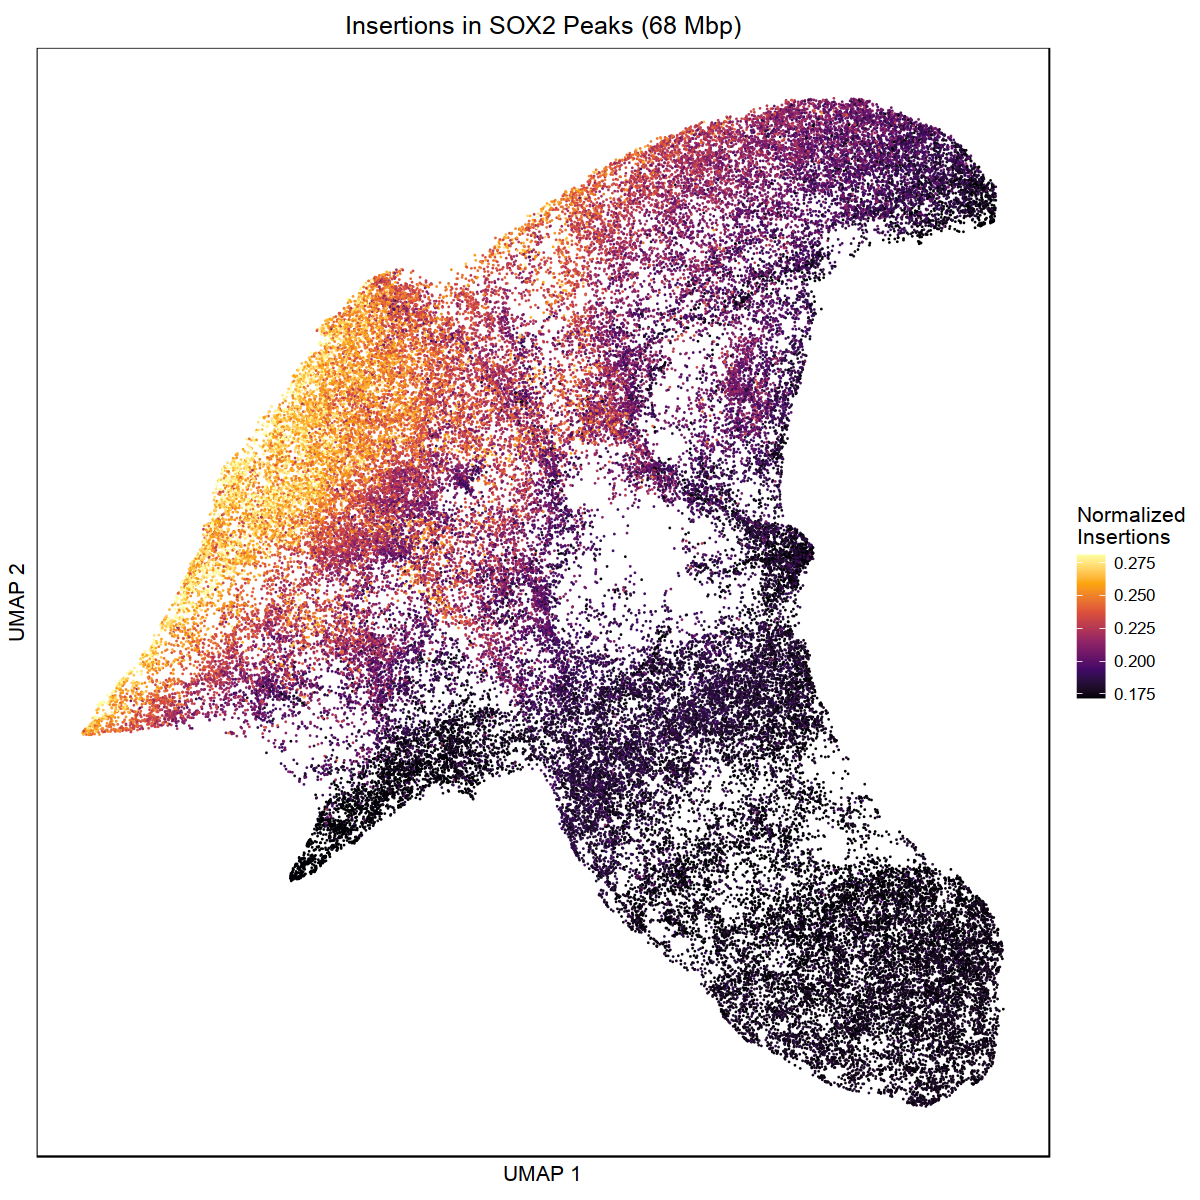

In [43]:
options(repr.plot.width = 10, repr.plot.height = 10)
SOX2_frip

In [44]:
saveRDS(SOX2_frip, file=sprintf("./Fig2/subfigs/%s_SOX2_frip.rds",
                                   format(Sys.Date(), "%Y%m%d")))

### KLF4

In [45]:
peak_intersect_KLF4 = peak_regions_gr[unique(queryHits(findOverlaps(peak_regions_gr, KLF4_motif_gr)))]
peak_intersect_KLF4

GRanges object with 130690 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]     chr1     817132-819324      *
       [2]     chr1     826576-828254      *
       [3]     chr1     842735-843235      *
       [4]     chr1     869645-870446      *
       [5]     chr1     904198-905035      *
       ...      ...               ...    ...
  [130686]     chrY 19869249-19870200      *
  [130687]     chrY 20560484-20561006      *
  [130688]     chrY 20574883-20576318      *
  [130689]     chrY 20648955-20649463      *
  [130690]     chrY 20925300-20925828      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [46]:
# reads_in_ipsc_peaks = Matrix::rowSums(pmat[, unique(queryHits(findOverlaps(peak_regions_gr, iPSC_peaks)))])/metaData$total_insertions
reads_in_KLF4_peaks = Matrix::rowSums(pmat[, unique(queryHits(findOverlaps(peak_regions_gr, KLF4_motif_gr)))])/pmatRowSums

In [52]:
min(reads_in_KLF4_peaks)
median(reads_in_KLF4_peaks)
max(reads_in_KLF4_peaks)

[1] 0.3990816

[1] 0.6403191

[1] 0.8536264

In [48]:
KLF4_frip = get_frip_plot(reads_in_KLF4_peaks, "Insertions in KLF4 Peaks", peak_intersect_KLF4)

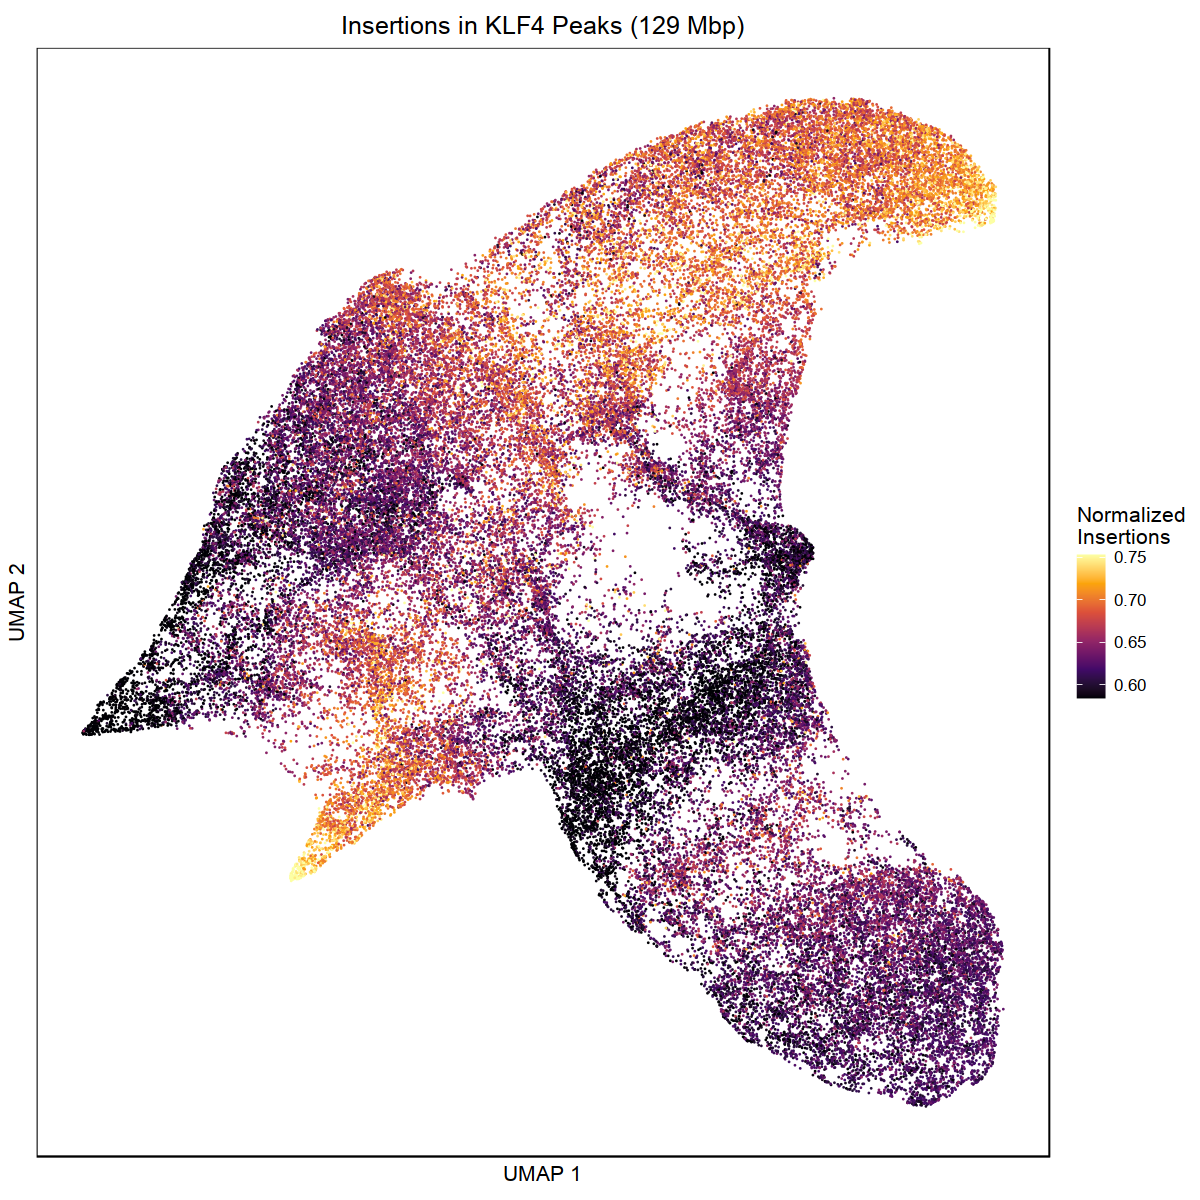

In [49]:
options(repr.plot.width = 10, repr.plot.height = 10)
KLF4_frip

In [50]:
saveRDS(KLF4_frip, file=sprintf("./Fig2/subfigs/%s_KLF4_frip.rds",
                                   format(Sys.Date(), "%Y%m%d")))

In [131]:
naive_gr = import("../../resources/GSE101074/naive.specific.atac.hg38.bed")
primed_gr = import("../../resources/GSE101074/primed.specific.atac.hg38.bed")

In [132]:
peak_intersect_naive = peak_regions_gr[unique(queryHits(findOverlaps(peak_regions_gr, naive_gr)))]
peak_intersect_primed = peak_regions_gr[unique(queryHits(findOverlaps(peak_regions_gr, primed_gr)))]
peak_intersect_naive

GRanges object with 4040 ranges and 0 metadata columns:
         seqnames              ranges strand
            <Rle>           <IRanges>  <Rle>
     [1]     chr1     1586097-1587548      *
     [2]     chr1     1758693-1760565      *
     [3]     chr1     1906150-1907877      *
     [4]     chr1     2131384-2131884      *
     [5]     chr1     2566062-2566898      *
     ...      ...                 ...    ...
  [4036]     chrX 150032382-150033498      *
  [4037]     chrX 150751482-150752577      *
  [4038]     chrX 150968833-150969835      *
  [4039]     chrX 150972311-150973213      *
  [4040]     chrX 153682460-153683286      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [133]:
# reads_in_ipsc_peaks = Matrix::rowSums(pmat[, unique(queryHits(findOverlaps(peak_regions_gr, iPSC_peaks)))])/metaData$total_insertions
reads_in_naive_peaks = Matrix::rowSums(pmat[, unique(queryHits(findOverlaps(peak_regions_gr, naive_gr)))])/pmatRowSums
reads_in_primed_peaks = Matrix::rowSums(pmat[, unique(queryHits(findOverlaps(peak_regions_gr, primed_gr)))])/pmatRowSums

In [134]:
min(reads_in_naive_peaks)
median(reads_in_naive_peaks)
max(reads_in_naive_peaks)

min(reads_in_primed_peaks)
median(reads_in_primed_peaks)
max(reads_in_primed_peaks)

[1] 0

[1] 0.009825859

[1] 0.05132991

[1] 0

[1] 0.009849212

[1] 0.03101462

In [135]:
naive_frip = get_frip_plot(reads_in_naive_peaks, "Insertions in Naive Specifc Peaks", peak_intersect_naive, upper_perc=.975)
primed_frip = get_frip_plot(reads_in_primed_peaks, "Insertions in Primed Specific Peaks", peak_intersect_primed, upper_perc=.975)

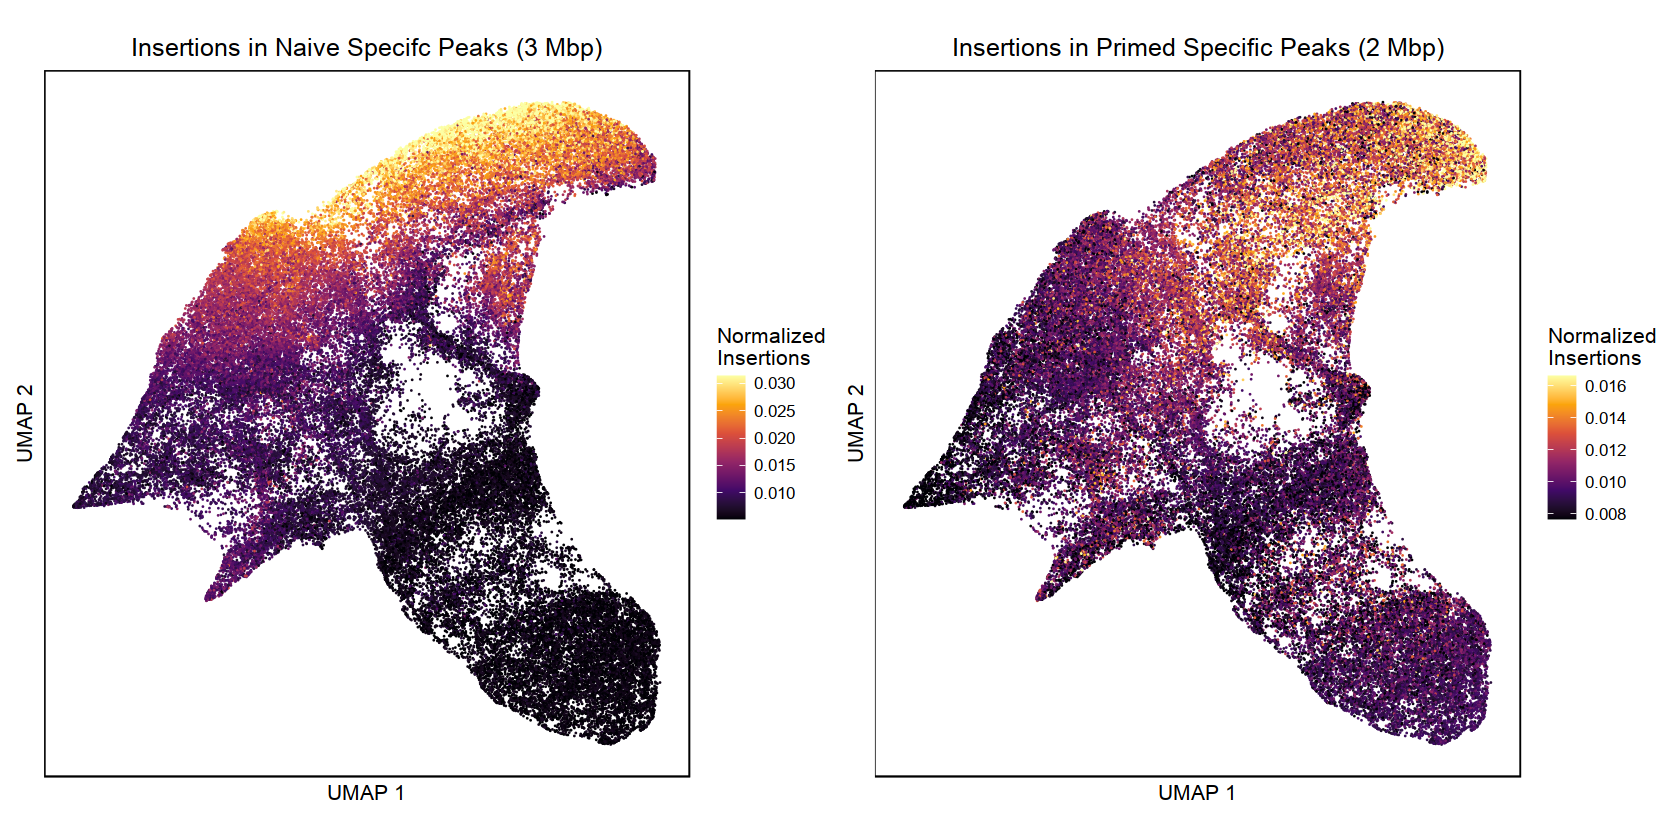

In [136]:
options(repr.plot.width = 14, repr.plot.height = 7)
naive_frip | primed_frip

In [50]:
saveRDS(KLF4_frip, file=sprintf("./Fig2/subfigs/%s_KLF4_frip.rds",
                                   format(Sys.Date(), "%Y%m%d")))